In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools


from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch
from iarchitect.common import show_policy_behaviour,create_policy_eval_video
from iarchitect.common.callbacks import output_updater,update_plotter,fig_trainer

from tf_agents.agents import DdpgAgent,DqnAgent

from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers

2022-03-07 21:31:05.068960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 21:31:05.069005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
SOLUTION_NAME = "WindowEnvWhatPlantrandomResetFalse"

In [7]:
environment = envs.WindowEnv(16,
                             np.fromiter(range(10),dtype=int),random_reset=False,
                            render_dims=(4,4))
environment.set_quotas(np.array([0,0,0,0,1,0,0,2,0,0]))
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

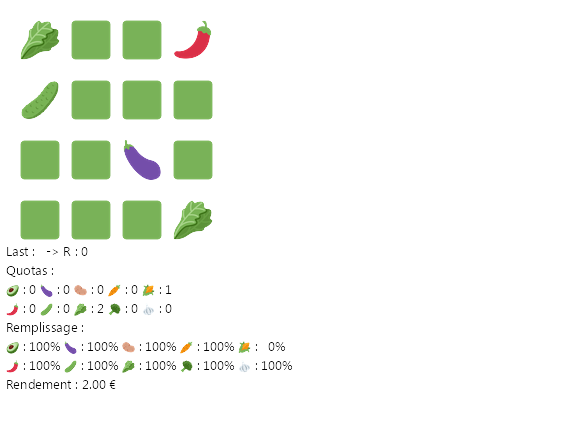

In [24]:
environment.reset()
environment.render_image()


In [8]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
def network(fc_layers_units,dimension_q_values):
    q_values_layer = layers.Dense(
            dimension_q_values,
            activation=None,
            kernel_initializer=initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=initializers.Constant(-0.2))
    return sequential.Sequential([layers.Flatten()] + [dense_layer(n) for n in fc_layers_units] + [q_values_layer])


In [72]:
agent = DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=network((20,20),len(environment.tuiles)),
        optimizer=Adam(learning_rate=0.0005),
        td_errors_loss_fn=common.element_wise_squared_loss,)
agent.initialize()

In [73]:
def plot_obs(obs,ax):
    return ax.imshow(obs,vmin=0.0,vmax=1.0)

def plot_traj(tr,ax):
    return ax.imshow(tr)

In [74]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.initialize_buffer(min_size=640,random_policy=True)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 9 (1,)
[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] (1,)
[10  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 2 (2,)
[10  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0] (2,)
[10  3 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 9 (3,)
[10  3 10  0  0  0  0  0  0  0  0  0  0  0  0  0] (3,)
[10  3 10  1  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 0 (4,)
[10  3 10  1  0  0  0  0  0  0  0  0  0  0  0  0] (4,)
[10  3 10  1  9  0  0  0  0  0  0  0  0  0  0  0]
0 False 8 (5,)
[10  3 10  1  9  0  0  0  0  0  0  0  0  0  0  0] (5,)
[10  3 10  1  9  6  0  0  0  0  0  0  0  0  0  0]
0.1 False 5 (6,)
[10  3 10  1  9  6  0  0  0  0  0  0  0  0  0  0] (6,)
[10  3 10  1  9  6  4  0  0  0  0  0  0  0  0  0]
0.1 False 3 (7,)
[10  3 10  1  9  6  4  0  0  0  0  0  0  0  0  0] (7,)
[10  3 10  1  9  6  4  7  0  0  0  0  0  0  0  0]
0 False 6 (8,)
[10  3 10  1  9  6  4  7  0  0  0  0  0  0  0  0] (8

[ 3  7 10  4  7  3  3  1  4  1 10  4  2  9  0  0] (14,)
[ 3  7 10  4  7  3  3  1  4  1 10  4  2  9  6  0]
0.1 False 5 (15,)
[ 3  7 10  4  7  3  3  1  4  1 10  4  2  9  6  0] (15,)
[ 3  7 10  4  7  3  3  1  4  1 10  4  2  9  6  6]
0.5 True 5 None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 1 (1,)
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[2 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 7 (2,)
[2 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[2 8 9 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 8 (3,)
[2 8 9 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[2 8 9 1 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 0 (4,)
[2 8 9 1 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[2 8 9 1 2 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (5,)
[2 8 9 1 2 0 0 0 0 0 0 0 0 0 0 0] (5,)
[2 8 9 1 2 2 0 0 0 0 0 0 0 0 0 0]
0 False 1 (6,)
[2 8 9 1 2 2 0 0 0 0 0 0 0 0 0 0] (6,)
[ 2  8  9  1  2  2 10  0  0  0  0  0  0  0  0  0]
0 False 9 (7,)
[ 2  8  9  1  2  2 10  0  0  0  0  0  0  0  0  0] (7,)
[ 2  8  9  1  2  2 10  6  0  0  0  0  0  0  0  0]
0.1 False 5 (

[ 6  5 10  6  9 10  9  1  9  5  5  3  1  6  1  0] (15,)
[ 6  5 10  6  9 10  9  1  9  5  5  3  1  6  1  6]
0.5 True 5 None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (1,)
[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[6 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 2 (2,)
[6 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 0 (3,)
[6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[6 3 1 6 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (4,)
[6 3 1 6 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[6 3 1 6 6 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (5,)
[6 3 1 6 6 0 0 0 0 0 0 0 0 0 0 0] (5,)
[6 3 1 6 6 5 0 0 0 0 0 0 0 0 0 0]
0 False 4 (6,)
[6 3 1 6 6 5 0 0 0 0 0 0 0 0 0 0] (6,)
[6 3 1 6 6 5 6 0 0 0 0 0 0 0 0 0]
0.1 False 5 (7,)
[6 3 1 6 6 5 6 0 0 0 0 0 0 0 0 0] (7,)
[ 6  3  1  6  6  5  6 10  0  0  0  0  0  0  0  0]
0 False 9 (8,)
[ 6  3  1  6  6  5  6 10  0  0  0  0  0  0  0  0] (8,)
[ 6  3  1  6  6  5  6 10  4  0  0  0  0  0  0  0]
0.1 False 3 (9,)
[ 6  3  1  6  6  5  6 10  4 

[ 8  3 10  2  4  3  2  0  0  0  0  0  0  0  0  0] (7,)
[ 8  3 10  2  4  3  2  7  0  0  0  0  0  0  0  0]
0 False 6 (8,)
[ 8  3 10  2  4  3  2  7  0  0  0  0  0  0  0  0] (8,)
[ 8  3 10  2  4  3  2  7  9  0  0  0  0  0  0  0]
0 False 8 (9,)
[ 8  3 10  2  4  3  2  7  9  0  0  0  0  0  0  0] (9,)
[ 8  3 10  2  4  3  2  7  9  1  0  0  0  0  0  0]
0 False 0 (10,)
[ 8  3 10  2  4  3  2  7  9  1  0  0  0  0  0  0] (10,)
[ 8  3 10  2  4  3  2  7  9  1  1  0  0  0  0  0]
0 False 0 (11,)
[ 8  3 10  2  4  3  2  7  9  1  1  0  0  0  0  0] (11,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  0  0  0  0]
0 False 1 (12,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  0  0  0  0] (12,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  4  0  0  0]
0.1 False 3 (13,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  4  0  0  0] (13,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  4  6  0  0]
0.1 False 5 (14,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  4  6  0  0] (14,)
[ 8  3 10  2  4  3  2  7  9  1  1  2  4  6  6  0]
0.1 False 5 (15,)
[ 8  3 10  2  4  3  2  

[ 2  5  9  1  7  5  2  3  6  5 10  2  2  5  1  0] (15,)
[ 2  5  9  1  7  5  2  3  6  5 10  2  2  5  1  4]
0.5 True 3 None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 3 (1,)
[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (2,)
[4 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[4 6 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 4 (3,)
[4 6 5 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[4 6 5 1 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 0 (4,)
[4 6 5 1 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[4 6 5 1 4 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 3 (5,)
[4 6 5 1 4 0 0 0 0 0 0 0 0 0 0 0] (5,)
[4 6 5 1 4 3 0 0 0 0 0 0 0 0 0 0]
0 False 2 (6,)
[4 6 5 1 4 3 0 0 0 0 0 0 0 0 0 0] (6,)
[4 6 5 1 4 3 7 0 0 0 0 0 0 0 0 0]
0 False 6 (7,)
[4 6 5 1 4 3 7 0 0 0 0 0 0 0 0 0] (7,)
[4 6 5 1 4 3 7 5 0 0 0 0 0 0 0 0]
0 False 4 (8,)
[4 6 5 1 4 3 7 5 0 0 0 0 0 0 0 0] (8,)
[4 6 5 1 4 3 7 5 8 0 0 0 0 0 0 0]
0.1 False 7 (9,)
[4 6 5 1 4 3 7 5 8 0 0 0 0 0 0 0] (9,)
[4 6 5 1 4 3 7 5 8 1 0 0 0 0 0 0]
0 Fal

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 9 (1,)
[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] (1,)
[10  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 0 (2,)
[10  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0] (2,)
[10  1  6  0  0  0  0  0  0  0  0  0  0  0  0  0]
0.1 False 5 (3,)
[10  1  6  0  0  0  0  0  0  0  0  0  0  0  0  0] (3,)
[10  1  6  9  0  0  0  0  0  0  0  0  0  0  0  0]
0 False 8 (4,)
[10  1  6  9  0  0  0  0  0  0  0  0  0  0  0  0] (4,)
[10  1  6  9  8  0  0  0  0  0  0  0  0  0  0  0]
0.1 False 7 (5,)
[10  1  6  9  8  0  0  0  0  0  0  0  0  0  0  0] (5,)
[10  1  6  9  8  8  0  0  0  0  0  0  0  0  0  0]
0.1 False 7 (6,)
[10  1  6  9  8  8  0  0  0  0  0  0  0  0  0  0] (6,)
[10  1  6  9  8  8  4  0  0  0  0  0  0  0  0  0]
0.1 False 3 (7,)
[10  1  6  9  8  8  4  0  0  0  0  0  0  0  0  0] (7,)
[10  1  6  9  8  8  4  5  0  0  0  0  0  0  0  0]
0 False 4 (8,)
[10  1  6  9  8  8  4  5  0  0  0  0  0  0  0  0

[9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[9 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 2 (2,)
[9 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[9 3 8 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 7 (3,)
[9 3 8 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[9 3 8 7 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 6 (4,)
[9 3 8 7 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[9 3 8 7 2 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 1 (5,)
[9 3 8 7 2 0 0 0 0 0 0 0 0 0 0 0] (5,)
[9 3 8 7 2 9 0 0 0 0 0 0 0 0 0 0]
0 False 8 (6,)
[9 3 8 7 2 9 0 0 0 0 0 0 0 0 0 0] (6,)
[ 9  3  8  7  2  9 10  0  0  0  0  0  0  0  0  0]
0 False 9 (7,)
[ 9  3  8  7  2  9 10  0  0  0  0  0  0  0  0  0] (7,)
[ 9  3  8  7  2  9 10 10  0  0  0  0  0  0  0  0]
0 False 9 (8,)
[ 9  3  8  7  2  9 10 10  0  0  0  0  0  0  0  0] (8,)
[ 9  3  8  7  2  9 10 10  7  0  0  0  0  0  0  0]
0 False 6 (9,)
[ 9  3  8  7  2  9 10 10  7  0  0  0  0  0  0  0] (9,)
[ 9  3  8  7  2  9 10 10  7  4  0  0  0  0  0  0]
0.1 False 3 (10,)
[ 9  3  8  7  2  9 10 10  7  4  0  0  0  0  0  0] (10,)
[ 9  3  8  7  2  9 10 10  7  4  7

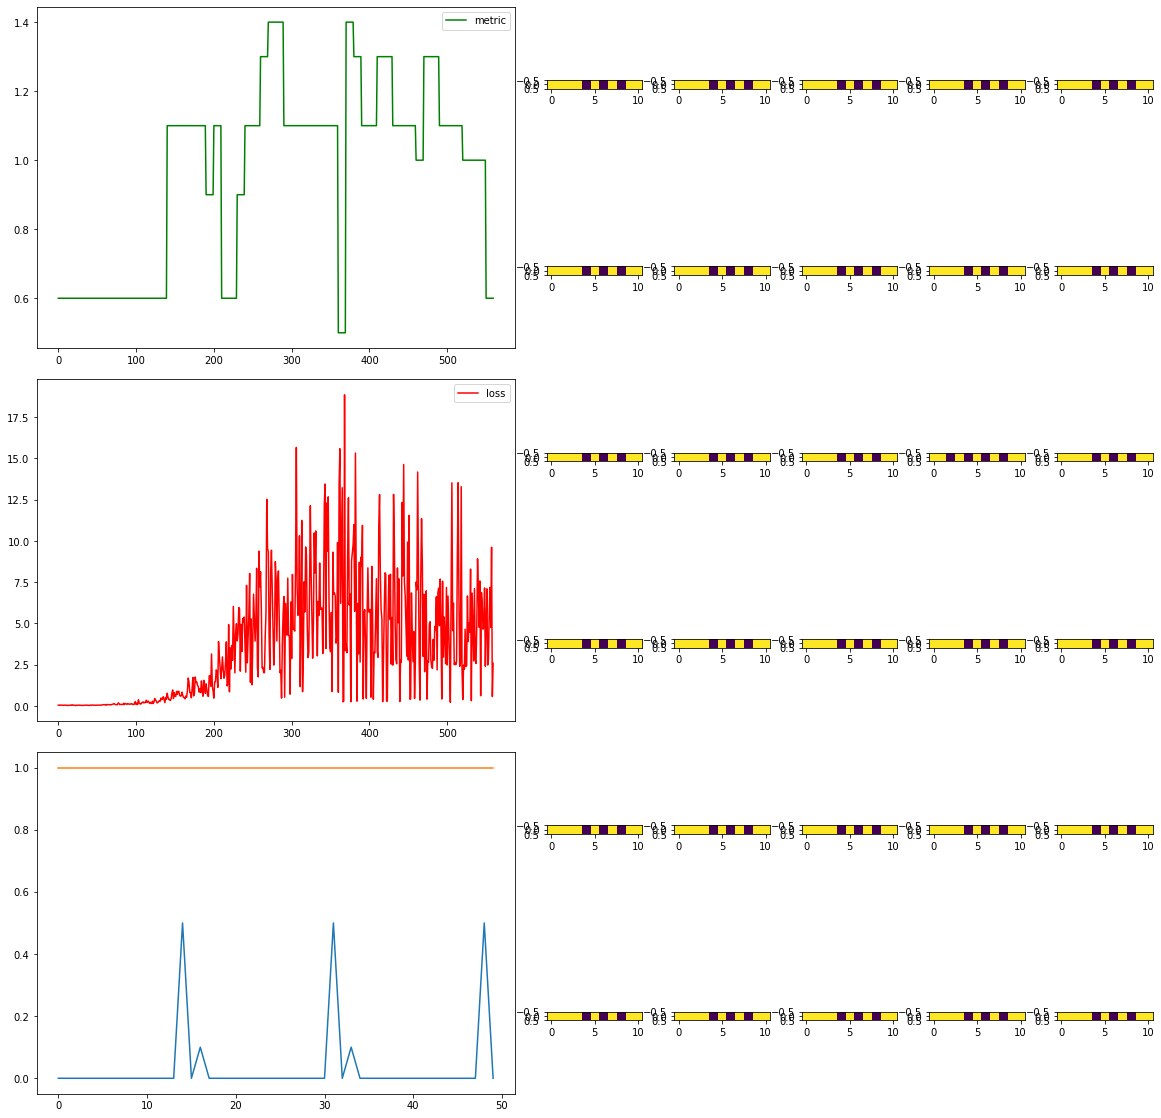

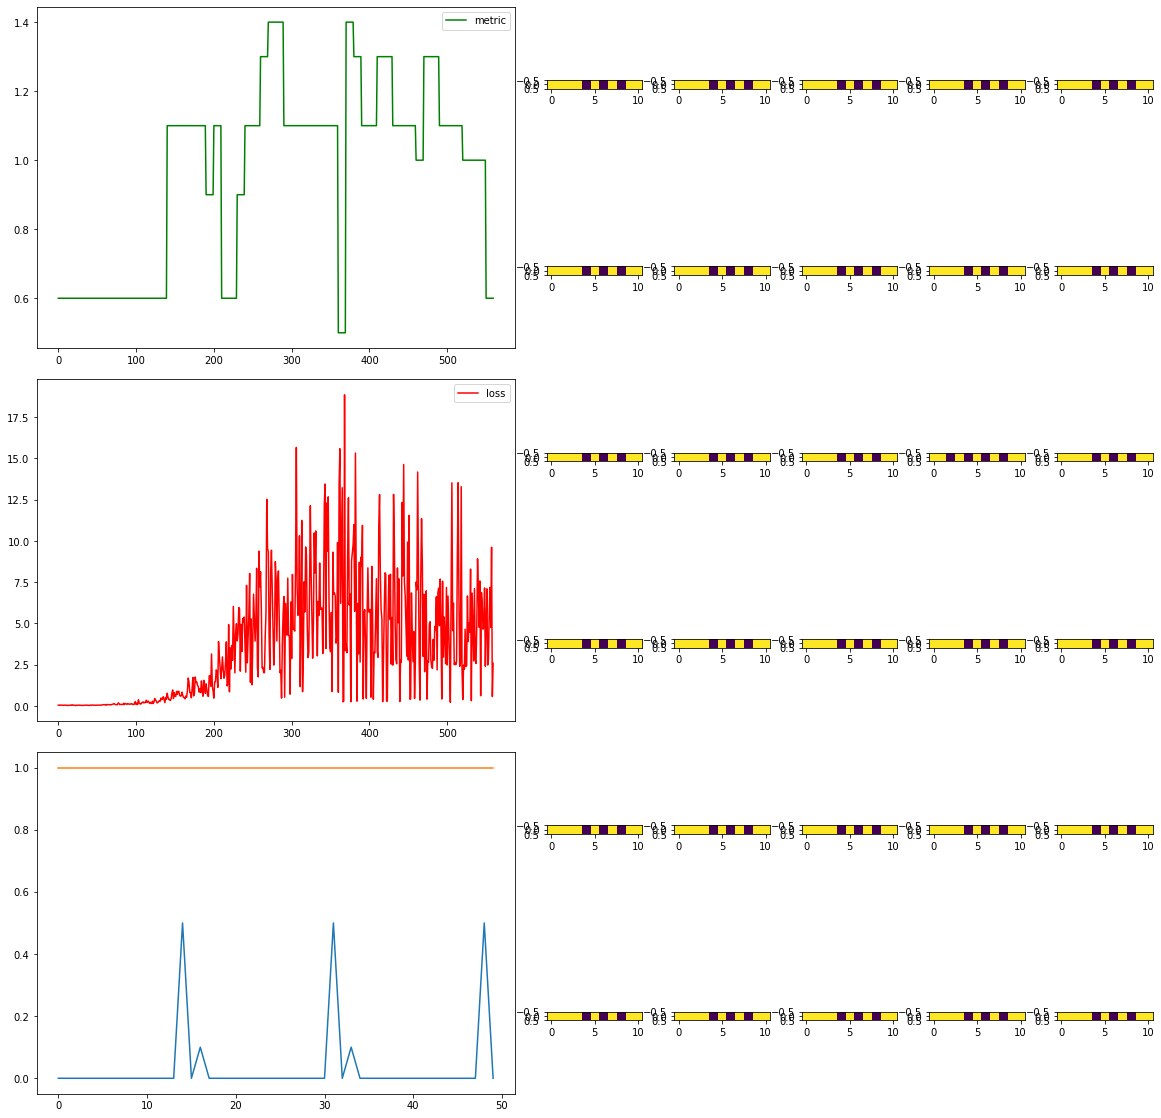

In [75]:
fig_tr = fig_trainer(6,6,figsize=(20,20))
callbacks = [update_plotter(fig_tr,plot_obs),
             output_updater(fig_tr,clear_output=True)
             ]

trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 10,
            sample_batch_size_experience = 64,
            num_iterations_train = 10,
            num_steps_per_row_in_experience = 2
           )

In [78]:
fig_tr.savefig(SOLUTION_NAME+".png")

In [ ]:
agent.policy.

In [76]:
create_policy_eval_video(train_env,environment,trainer.agent.policy,SOLUTION_NAME,num_episodes=10,fps=5)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 1 (1,)
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (2,)
[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (3,)
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (4,)
[2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (5,)
[2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0] (5,)
[2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
0 False 1 (6,)
[2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0] (6,)
[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
0 False 1 (7,)
[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0] (7,)
[2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0]
0 False 1 (8,)
[2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0] (8,)
[2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0]
0 False 1 (9,)
[2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0] (9,)
[2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0]
0 False 1 (10,)
[2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0] (10,)
[2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0]
0 False 1 (11,)
[2 2 2 2 2 2 2 2 2 2 2 0 0 

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0] (14,)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0]
0 False 1 (15,)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0] (15,)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
0.5 True 1 None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 1 (1,)
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (2,)
[2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (3,)
[2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (4,)
[2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
0 False 1 (5,)
[2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0] (5,)
[2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
0 False 1 (6,)
[2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0] (6,)
[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
0 False 1 (7,)
[2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0] (7,)
[2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0]
0 False 1 (8,)
[2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0] (8,)
[2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0]
0 False 1 (9,)
[2 2 2 2 2 2 2 2 2 0 0 0 0

In [77]:
create_policy_eval_video(train_env,environment,random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec()),SOLUTION_NAME + "_random",num_episodes=10,fps=5)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 6 (1,)
[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[7 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 7 (2,)
[7 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[7 8 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 1 (3,)
[7 8 2 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[7 8 2 6 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (4,)
[7 8 2 6 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[7 8 2 6 1 0 0 0 0 0 0 0 0 0 0 0]
0 False 0 (5,)
[7 8 2 6 1 0 0 0 0 0 0 0 0 0 0 0] (5,)
[7 8 2 6 1 4 0 0 0 0 0 0 0 0 0 0]
0.1 False 3 (6,)
[7 8 2 6 1 4 0 0 0 0 0 0 0 0 0 0] (6,)
[7 8 2 6 1 4 6 0 0 0 0 0 0 0 0 0]
0.1 False 5 (7,)
[7 8 2 6 1 4 6 0 0 0 0 0 0 0 0 0] (7,)
[7 8 2 6 1 4 6 8 0 0 0 0 0 0 0 0]
0.1 False 7 (8,)
[7 8 2 6 1 4 6 8 0 0 0 0 0 0 0 0] (8,)
[7 8 2 6 1 4 6 8 7 0 0 0 0 0 0 0]
0 False 6 (9,)
[7 8 2 6 1 4 6 8 7 0 0 0 0 0 0 0] (9,)
[7 8 2 6 1 4 6 8 7 5 0 0 0 0 0 0]
0 False 4 (10,)
[7 8 2 6 1 4 6 8 7 5 0 0 0 0 0 0] (10,)
[7 8 2 6 1 4 6 8 7 5 2 0 0 0 0 0]
0 False 1 (11,)
[7 8 2 6 1 4 6 8 

[ 5  5  8  9  5 10  5  5  6  9  3  8  8  8  9  0] (15,)
[ 5  5  8  9  5 10  5  5  6  9  3  8  8  8  9  5]
0.5 True 4 None
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (0,)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 0 (1,)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (1,)
[1 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 7 (2,)
[1 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (2,)
[1 8 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (3,)
[1 8 6 0 0 0 0 0 0 0 0 0 0 0 0 0] (3,)
[1 8 6 5 0 0 0 0 0 0 0 0 0 0 0 0]
0 False 4 (4,)
[1 8 6 5 0 0 0 0 0 0 0 0 0 0 0 0] (4,)
[1 8 6 5 6 0 0 0 0 0 0 0 0 0 0 0]
0.1 False 5 (5,)
[1 8 6 5 6 0 0 0 0 0 0 0 0 0 0 0] (5,)
[1 8 6 5 6 5 0 0 0 0 0 0 0 0 0 0]
0 False 4 (6,)
[1 8 6 5 6 5 0 0 0 0 0 0 0 0 0 0] (6,)
[1 8 6 5 6 5 8 0 0 0 0 0 0 0 0 0]
0.1 False 7 (7,)
[1 8 6 5 6 5 8 0 0 0 0 0 0 0 0 0] (7,)
[1 8 6 5 6 5 8 7 0 0 0 0 0 0 0 0]
0 False 6 (8,)
[1 8 6 5 6 5 8 7 0 0 0 0 0 0 0 0] (8,)
[1 8 6 5 6 5 8 7 9 0 0 0 0 0 0 0]
0 False 8 (9,)
[1 8 6 5 6 5 8 7 9 0 0 0 0 0 0 0] (9,)
[1 8 6 5 6 5 8 7 9 6 0 0 0 0 0 0]
0.1 F

[10  7  7 10  6  9  7  8  0  0  0  0  0  0  0  0] (8,)
[10  7  7 10  6  9  7  8  9  0  0  0  0  0  0  0]
0 False 8 (9,)
[10  7  7 10  6  9  7  8  9  0  0  0  0  0  0  0] (9,)
[10  7  7 10  6  9  7  8  9  2  0  0  0  0  0  0]
0.1 False 1 (10,)
[10  7  7 10  6  9  7  8  9  2  0  0  0  0  0  0] (10,)
[10  7  7 10  6  9  7  8  9  2 10  0  0  0  0  0]
0 False 9 (11,)
[10  7  7 10  6  9  7  8  9  2 10  0  0  0  0  0] (11,)
[10  7  7 10  6  9  7  8  9  2 10  1  0  0  0  0]
0 False 0 (12,)
[10  7  7 10  6  9  7  8  9  2 10  1  0  0  0  0] (12,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  0  0  0]
0 False 6 (13,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  0  0  0] (13,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  9  0  0]
0 False 8 (14,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  9  0  0] (14,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  9  6  0]
0.1 False 5 (15,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  9  6  0] (15,)
[10  7  7 10  6  9  7  8  9  2 10  1  7  9  6 10]
0.5 True 9 None
